In [ ]:
!pip install -q pandas numpy scikit-learn joblib

In [ ]:
import os, re, json, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, classification_report
)
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
DATA_PATH = "/content/used_cars_price.csv"
df_raw = pd.read_csv(DATA_PATH)
print("Loaded:", df_raw.shape)
df_raw.head()

Loaded: (4009, 15)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,seats,torque_nm,mileage_kmpl
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300",5,500.0,9.670861
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005",5,513.0,14.668329
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598",5,472.0,11.908315
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500",5,472.0,12.787168
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999",5,270.0,9.996964


In [ ]:
df = df_raw.copy()
df.columns = (
    df.columns.str.strip().str.lower()
      .str.replace(" ", "_").str.replace("-", "_")
)
aliases = {
    "price": ["price", "selling_price"],
    "year": ["year", "model_year"],
    "km_driven": ["km_driven", "odometer", "kms_driven", "km", "milage"],
    "mileage": ["mileage", "avg_mileage", "mileage_(kmpl)", "mileage_kmpl"],
    "engine": ["engine", "engine_cc", "engine_capacity"],
    "max_power": ["max_power", "power", "bhp", "power_bhp"],
    "torque": ["torque", "torque_nm"],
    "fuel": ["fuel", "fuel_type"],
    "transmission": ["transmission", "gearbox"],
    "owner": ["owner", "owners", "owner_type"],
    "seats": ["seats"],
    "name": ["name", "car_name", "model", "title"]
}
def pick_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None
canon = {k: pick_col(v) for k, v in aliases.items()}
print(canon)

{'price': 'price', 'year': 'model_year', 'km_driven': 'milage', 'mileage': 'mileage_kmpl', 'engine': 'engine', 'max_power': None, 'torque': 'torque_nm', 'fuel': 'fuel_type', 'transmission': 'transmission', 'owner': None, 'seats': 'seats', 'name': 'model'}


In [ ]:
def extract_float(s):
    if pd.isna(s): return np.nan
    m = re.findall(r"(\d*\.?\d+)\s*(HP|L|Liter|CC|V\d|Cylinder|Nm|nm|lb-ft|lbft|rpm|kmpl|km/kg)?", str(s).replace(",", ""))
    if m:
        for value, unit in m:
            value = float(value)
            unit = unit.lower() if unit else ''
            if 'hp' in unit: return value
            if 'cc' in unit: return value
            if 'nm' in unit: return value
            if 'lb-ft' in unit or 'lbft' in unit: return value * 1.356
            if 'kmpl' in unit or 'km/kg' in unit: return value
        for value, unit in m:
             value = float(value)
             unit = unit.lower() if unit else ''
             if 'l' in unit or 'liter' in unit:
                return value
    m_fallback = re.findall(r"[\d\.]+", str(s).replace(",", ""))
    return float(m_fallback[0]) if m_fallback else np.nan
def parse_engine_cc(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    m_cc = re.search(r"(\d*\.?\d+)\s*cc", s)
    if m_cc: return float(m_cc.group(1))
    m_liter = re.search(r"(\d*\.?\d+)\s*l(?:iter)?", s)
    if m_liter: return float(m_liter.group(1)) * 1000
    return np.nan
def parse_power_bhp(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    m_hp = re.search(r"(\d*\.?\d+)\s*hp", s)
    if m_hp: return float(m_hp.group(1))
    m_bhp = re.search(r"(\d*\.?\d+)\s*bhp", s)
    if m_bhp: return float(m_bhp.group(1))
    return np.nan
def parse_mileage_kmpl_simplified(x_canonical, x_engine):
    if pd.notna(x_canonical):
        return extract_float(x_canonical)
    elif pd.notna(x_engine):

        s = str(x_engine).lower()
        m_kmpl = re.search(r"(\d*\.?\d+)\s*kmpl", s)
        if m_kmpl: return float(m_kmpl.group(1))
        m_kmkg = re.search(r"(\d*\.?\d+)\s*km/kg", s)
        if m_kmkg: return float(m_kmkg.group(1)) * 0.9
    return np.nan

def parse_torque_nm_simplified(x_canonical, x_engine):
    if pd.notna(x_canonical):
        return extract_float(x_canonical)
    elif pd.notna(x_engine):

        s = str(x_engine).lower()
        m_nm = re.search(r"(\d*\.?\d+)\s*nm", s)
        if m_nm: return float(m_nm.group(1))
        m_lbft = re.search(r"(\d*\.?\d+)\s*lb-?ft", s)
        if m_lbft: return float(m_lbft.group(1)) * 1.356
    return np.nan


# Build numeric fields with graceful fallbacks
# Apply the improved parsing functions
df["engine_cc"]   = df[canon["engine"]].apply(parse_engine_cc)   if canon["engine"] else np.nan
df["power_bhp"]   = df[canon["max_power"]].apply(parse_power_bhp) if canon["max_power"] else df[canon["engine"]].apply(parse_power_bhp)

# Use simplified parsing that prioritizes canonical columns
df["mileage_kmpl"]= df.apply(lambda row: parse_mileage_kmpl_simplified(row.get(canon["mileage"]), row.get(canon["engine"])), axis=1)
df["torque_nm"]   = df.apply(lambda row: parse_torque_nm_simplified(row.get(canon["torque"]), row.get(canon["engine"])), axis=1)

# Base fields
df["price"]       = df[canon["price"]].apply(extract_float) if canon["price"] else np.nan
df["year"]        = df[canon["year"]] if canon["year"] else np.nan
# km_driven should still primarily come from the original milage column
df["km_driven"]   = df["milage"].apply(extract_float) if "milage" in df.columns else np.nan
df["fuel"]        = df[canon["fuel"]] if canon["fuel"] else "Unknown"
df["transmission"]= df[canon["transmission"]] if canon["transmission"] else "Unknown"
df["owner_raw"]   = df[canon["owner"]] if canon["owner"] else "Unknown"
df["seats"]       = df[canon["seats"]].apply(extract_float) if canon["seats"] else np.nan
df["name"]        = df[canon["name"]] if canon["name"] else "Unknown"


print(df[["price","year","km_driven","engine_cc","power_bhp","mileage_kmpl","torque_nm","fuel","transmission","seats"]].head())
print("\nCanonical column mapping:", canon)

     price  year  km_driven  engine_cc  power_bhp  mileage_kmpl  torque_nm  \
0  10300.0  2013    51000.0     3700.0      300.0      9.670861      500.0   
1  38005.0  2021    34742.0     3800.0        NaN     14.668329      513.0   
2  54598.0  2022    22372.0     3500.0        NaN     11.908315      472.0   
3  15500.0  2015    88900.0     3500.0      354.0     12.787168      472.0   
4  34999.0  2021     9835.0     2000.0        NaN      9.996964      270.0   

            fuel       transmission  seats  
0  E85 Flex Fuel        6-Speed A/T    5.0  
1       Gasoline  8-Speed Automatic    5.0  
2       Gasoline          Automatic    5.0  
3         Hybrid        7-Speed A/T    5.0  
4       Gasoline  8-Speed Automatic    5.0  

Canonical column mapping: {'price': 'price', 'year': 'model_year', 'km_driven': 'milage', 'mileage': 'mileage_kmpl', 'engine': 'engine', 'max_power': None, 'torque': 'torque_nm', 'fuel': 'fuel_type', 'transmission': 'transmission', 'owner': None, 'seats': 'sea

In [ ]:
# Remove crazy outliers that break training
df = df[(df["price"] > 1e4) & (df["price"] < 2e8)]
df = df[(df["year"] >= 1995) & (df["year"] <= 2025)]
df = df[df["km_driven"] >= 0]

# Winsorize numeric extremes
for col in ["km_driven","engine_cc","power_bhp","mileage_kmpl","torque_nm","price"]:
    if col in df:
        lo, hi = df[col].quantile([0.01, 0.99])
        df[col] = df[col].clip(lo, hi)

df = df.dropna(subset=["price","year","km_driven"])
print("After cleaning:", df.shape)


After cleaning: (3556, 22)


In [ ]:
# Create car_age feature
current_year = pd.Timestamp.now().year
df["car_age"] = current_year - df["year"]

# Convert price to numeric (already mostly done earlier)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Drop rows with missing values for depreciation fitting
fit_df = df.dropna(subset=["car_age", "price"])

# Fit quadratic depreciation curve if possible
if len(fit_df) > 0:
    coef = np.polyfit(fit_df["car_age"], np.log1p(fit_df["price"]), deg=2)
    baseline = np.polyval(coef, df["car_age"])
    df["price_depr_residual"] = np.log1p(df["price"]) - baseline
else:
    df["price_depr_residual"] = np.nan
    print("⚠️ No valid rows for depreciation curve")


In [ ]:
print(df[["year","car_age","price"]].head(20))
print("Nulls in car_age:", df["car_age"].isna().sum())
print("Nulls in price:", df["price"].isna().sum())


    year  car_age      price
0   2013       12   10774.75
1   2021        4   38005.00
2   2022        3   54598.00
3   2015       10   15500.00
4   2021        4   34999.00
5   2016        9   14798.00
6   2017        8   31000.00
8   2021        4   41927.00
9   2020        5   69950.00
10  2021        4   73897.00
11  2019        6  184606.00
12  2021        4   53500.00
13  2022        3   62000.00
14  2020        5   47998.00
15  2013       12   29990.00
16  2021        4  250000.00
17  2013       12   16800.00
18  2003       22   11000.00
19  2018        7   68750.00
20  2023        2   60000.00
Nulls in car_age: 0
Nulls in price: 0


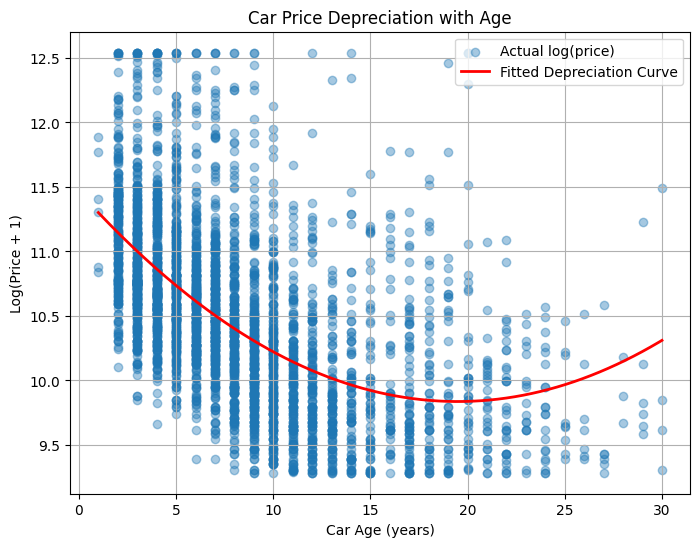

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

valid = df.dropna(subset=["car_age", "price"])
valid = valid[valid["price"] > 0]

if not valid.empty:
    coef = np.polyfit(valid["car_age"], np.log1p(valid["price"]), deg=2)
    baseline = np.polyval(coef, df["car_age"])
    df["price_depr_residual"] = np.log1p(df["price"]) - baseline

    plt.figure(figsize=(8,6))
    plt.scatter(valid["car_age"], np.log1p(valid["price"]), alpha=0.4, label="Actual log(price)")
    x_range = np.linspace(valid["car_age"].min(), valid["car_age"].max(), 200)
    y_fit = np.polyval(coef, x_range)
    plt.plot(x_range, y_fit, color="red", linewidth=2, label="Fitted Depreciation Curve")
    plt.xlabel("Car Age (years)")
    plt.ylabel("Log(Price + 1)")
    plt.title("Car Price Depreciation with Age")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No valid rows for depreciation curve")


In [ ]:
# engineered features
df["km_per_year"] = df["km_driven"] / (df["car_age"] + 1)  # +1 to avoid div by 0

# Power-to-weight ratio proxy (if torque/engine available)
if "engine_cc" in df and "power_bhp" in df:
    df["power_per_cc"] = df["power_bhp"] / (df["engine_cc"] + 1)

# Fuel efficiency score (mileage normalized by engine size)
if "mileage_kmpl" in df and "engine_cc" in df:
    df["fuel_eff_score"] = df["mileage_kmpl"] / (df["engine_cc"] / 1000 + 1)

# Condition score (simple: newer, fewer km, fewer accidents = better)
df["condition_score"] = (
    -0.05 * df["car_age"] +
    -0.00001 * df["km_driven"] +
    (df["accident"].map({"Yes": -1, "No": 1}).fillna(0) if "accident" in df else 0)
)


In [ ]:
# Car Age
if "car_age" not in df:
    df["car_age"] = 2025 - df["year"]

# Power-to-weight ratio
df["power_to_weight"] = df["power_bhp"] / (df["engine_cc"].replace(0, np.nan))
df["power_to_weight"] = df["power_to_weight"].fillna(0)

# Efficiency score = mileage normalized
df["fuel_efficiency_score"] = (df["mileage_kmpl"] / df["mileage_kmpl"].max()).fillna(0)

# Synthetic "overall performance score"
df["performance_score"] = (
    0.4 * df["power_to_weight"] +
    0.3 * df["fuel_efficiency_score"] +
    0.3 * df["price_depr_residual"].fillna(0)
)

print(df[["price","car_age","power_to_weight","fuel_efficiency_score","performance_score"]].head())


      price  car_age  power_to_weight  fuel_efficiency_score  \
0  10774.75       12         0.081081               0.646892   
1  38005.00        4         0.000000               0.981176   
2  54598.00        3         0.000000               0.796557   
3  15500.00       10         0.101143               0.855344   
4  34999.00        4         0.000000               0.668705   

   performance_score  
0          -0.011074  
1           0.198625  
2           0.210810  
3           0.124929  
4           0.080164  


In [ ]:
# Features (drop target columns to avoid leakage)
feature_cols = [
    "year","km_driven","engine_cc","power_bhp","mileage_kmpl","torque_nm",
    "seats","fuel","transmission","owner_raw","name",
    "car_age","power_to_weight","fuel_efficiency_score","price_depr_residual"
]

# Keep only existing features
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols]

# Targets
y_price = df["price"]
y_perf = df["performance_score"]


In [ ]:
X_train, X_test, y_price_train, y_price_test, y_perf_train, y_perf_test = train_test_split(
    X, y_price, y_perf, test_size=0.2, random_state=42
)


In [ ]:
# Separate categorical and numeric
categorical = X.select_dtypes(include=["object"]).columns.tolist()
numeric = X.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical)
])


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from packaging import version
import sklearn
import numpy as np
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # new versions
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
# Update preprocessor
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", ohe)
    ]), categorical)
])

# Price prediction pipeline
price_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

# Train
price_model.fit(X_train, y_price_train)

# Predict
y_price_pred = price_model.predict(X_test)

# Evaluate
print("Price Prediction Performance:")
print(" MAE:", mean_absolute_error(y_price_test, y_price_pred))

# RMSE manually (works across versions)
rmse = np.sqrt(mean_squared_error(y_price_test, y_price_pred))
print(" RMSE:", rmse)

print(" R²:", r2_score(y_price_test, y_price_pred))


Price Prediction Performance:
 MAE: 1444.2629149018774
 RMSE: 5231.071569163358
 R²: 0.9856942617451383


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Reuse version-compatible OneHotEncoder
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessor for classification
preprocessor_class = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", ohe)
    ]), categorical)
])

# Convert continuous performance_score to discrete categories
# Using quantiles to define bin edges
bins = y_perf_train.quantile([0, 0.33, 0.67, 1]).tolist()
labels = ['low', 'medium', 'high']
y_perf_train_cat = pd.cut(y_perf_train, bins=bins, labels=labels, include_lowest=True)
y_perf_test_cat = pd.cut(y_perf_test, bins=bins, labels=labels, include_lowest=True)


# Classification pipeline
class_model = Pipeline([
    ("preprocess", preprocessor_class),
    ("model", RandomForestClassifier(random_state=42))
])

# Train using the categorical target
class_model.fit(X_train, y_perf_train_cat)

# Predict using the categorical target
y_class_pred = class_model.predict(X_test)

# Ensure predicted values are the same type as the test categories
y_class_pred = pd.Categorical(y_class_pred, categories=labels, ordered=True)

# Create a DataFrame from the actual and predicted categories to easily drop NaNs
eval_df = pd.DataFrame({'actual': y_perf_test_cat, 'predicted': y_class_pred})
eval_df = eval_df.dropna()

# Evaluate using the filtered data
print("Classification Performance:")
print(" Accuracy:", accuracy_score(eval_df['actual'], eval_df['predicted']))
print(" Confusion Matrix:\n", confusion_matrix(eval_df['actual'], eval_df['predicted']))
print(" Classification Report:\n", classification_report(eval_df['actual'], eval_df['predicted']))

Classification Performance:
 Accuracy: 0.9185393258426966
 Confusion Matrix:
 [[215   0  19]
 [  0 225  17]
 [ 12  10 214]]
 Classification Report:
               precision    recall  f1-score   support

        high       0.95      0.92      0.93       234
         low       0.96      0.93      0.94       242
      medium       0.86      0.91      0.88       236

    accuracy                           0.92       712
   macro avg       0.92      0.92      0.92       712
weighted avg       0.92      0.92      0.92       712



In [ ]:
#Feature Importance for classification model

# Get the fitted preprocessor from the pipeline
fitted_preprocessor = class_model.named_steps['preprocess']

# Get the transformed training data to access the feature names in the correct order
X_train_transformed = fitted_preprocessor.transform(X_train)

# Get feature names after preprocessing
# For scikit-learn versions >= 1.0, use get_feature_names_out
if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    all_features = fitted_preprocessor.get_feature_names_out(X.columns)
else:
    # For older versions, manually combine names (less robust)
    # This part might still be problematic depending on the exact sklearn version and data
    num_features = numeric
    cat_feature_names = fitted_preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names(categorical)
    all_features = np.concatenate([num_features, cat_feature_names])


# Get feature importances from the trained model
importances = class_model.named_steps['model'].feature_importances_

# Create a DataFrame - ensure the length of all_features matches importances
# Before creating the DataFrame, let's check the lengths as a safeguard
if len(all_features) != len(importances):
    print(f"Error: Mismatch in feature names ({len(all_features)}) and importances ({len(importances)}) lengths.")
else:
    feat_imp_df = pd.DataFrame({
        "feature": all_features,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    print("\nTop 15 Important Features for Classification:")
    print(feat_imp_df.head(15))


Top 15 Important Features for Classification:
                                             feature  importance
10                          num__price_depr_residual    0.257012
3                                     num__power_bhp    0.075008
1                                     num__km_driven    0.059790
4                                  num__mileage_kmpl    0.059528
9                         num__fuel_efficiency_score    0.058591
5                                     num__torque_nm    0.054398
2                                     num__engine_cc    0.051744
8                               num__power_to_weight    0.049178
0                                          num__year    0.029782
7                                       num__car_age    0.028294
50                             cat__transmission_A/T    0.006630
44                     cat__transmission_8-Speed A/T    0.005309
69  cat__transmission_Transmission w/Dual Shift Mode    0.005093
13                                cat__fuel

In [ ]:
from sklearn.model_selection import cross_val_score
import pandas as pd
# Regression cross-validation (R² score) - This part uses the continuous y_price, which is correct.
reg_scores = cross_val_score(price_model, X, y_price, cv=5, scoring="r2")
print("\nCross-Validation (Regression R²):", reg_scores)
print(" Mean R²:", reg_scores.mean())

# Classification cross-validation (Accuracy score)
# Convert the full y_perf to categorical using the same bins as before
bins = y_perf_train.quantile([0, 0.33, 0.67, 1]).tolist()
labels = ['low', 'medium', 'high']
y_perf_cat = pd.cut(y_perf, bins=bins, labels=labels, include_lowest=True)

# Remove any NaNs created by binning before cross-validation
temp_df = pd.DataFrame({'X_index': X.index, 'y_perf_cat': y_perf_cat})
valid_indices = temp_df.dropna()['X_index']

X_valid = X.loc[valid_indices]
y_perf_cat_valid = y_perf_cat.loc[valid_indices]

clf_scores = cross_val_score(class_model, X_valid, y_perf_cat_valid, cv=5, scoring="accuracy")
print("\nCross-Validation (Classification Accuracy):", clf_scores)
print(" Mean Accuracy:", clf_scores.mean())


Cross-Validation (Regression R²): [0.98074907 0.99456661 0.98746245 0.97750651 0.98116681]
 Mean R²: 0.9842902899554277

Cross-Validation (Classification Accuracy): [0.88904494 0.87341772 0.90998594 0.90014065 0.91983122]
 Mean Accuracy: 0.898484094249277


In [ ]:
#Show predictions with original values
# Pick a few indices from test set
sample_idx = X_test.sample(5, random_state=42).index
# Get original rows from df
sample_original = df.loc[sample_idx]

# Predict price & performance on X_test for those rows
pred_price = price_model.predict(X_test.loc[sample_idx])
pred_perf = class_model.predict(X_test.loc[sample_idx])

print("\nExample Predictions (with original car details):")
for i, idx in enumerate(sample_idx):
    row = sample_original.loc[idx]
    print(f"\nCar {i+1}:")
    # Display row as a dictionary, formatting specific keys for display
    row_dict = row.to_dict()
    formatted_dict = {}
    for key, value in row_dict.items():
        if key in ["torque_nm", "mileage_kmpl", "seats", "year", "model_year", "km_driven", "engine_cc", "power_bhp", "price"] and pd.notna(value):
            if isinstance(value, (int, float)) and value == int(value):
                formatted_dict[key] = int(value)
            elif isinstance(value, float):
                 formatted_dict[key] = round(value, 2)
            else:
                 formatted_dict[key] = value
        else:
            formatted_dict[key] = value
    print(formatted_dict)
    print(f" → Predicted Price: {pred_price[i]:,.0f}")
    print(f" → Predicted Performance: {pred_perf[i]}")
    print("-"*50)


Example Predictions (with original car details):

Car 1:
{'brand': 'Ford', 'model': 'Transit-350 Base', 'model_year': 2023, 'milage': '195 mi.', 'fuel_type': 'Gasoline', 'engine': '310.0HP 3.5L V6 Cylinder Engine Gasoline Fuel', 'transmission': '10-Speed A/T', 'ext_col': 'Blue', 'int_col': 'Gray', 'accident': 'None reported', 'clean_title': 'Yes', 'price': 87500, 'seats': 5, 'torque_nm': 472, 'mileage_kmpl': 13.75, 'engine_cc': 3500, 'power_bhp': 310, 'year': 2023, 'km_driven': 538.85, 'fuel': 'Gasoline', 'owner_raw': 'Unknown', 'name': 'Transit-350 Base', 'car_age': 2, 'price_depr_residual': 0.23216952846394, 'km_per_year': 179.61666666666667, 'power_per_cc': 0.08854612967723507, 'fuel_eff_score': 3.0562417323398594, 'condition_score': -0.10538850000000001, 'power_to_weight': 0.08857142857142856, 'fuel_efficiency_score': 0.9199552242411639, 'performance_score': 0.3810659972401026}
 → Predicted Price: 86,980
 → Predicted Performance: high
----------------------------------------------